In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import ipdb
import keras
import pandas as pd

sys.path.append('../../../')
import feedforward_robust as ffr

sys.path.append('../../../utils/')
from utils.mnist_corruption import *
from utils.utils_models import *
from utils.utils_analysis import *
from utils.utils_feedforward import *

%load_ext autoreload
%autoreload 2

#Read the counter
ctr_file = "../../counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "../../logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

Using TensorFlow backend.
W0716 15:31:41.394906 4654771648 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/cleverhans/utils_tf.py:341: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



# Get Fashion MNIST Data

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train/255
x_test = x_test/255

In [4]:
#One hot the labels
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)                                                                                         
y_test = keras.utils.to_categorical(y_test, num_classes)

In [5]:
x_train_master, y_train_master = x_train[:30000], y_train[:30000]
x_train_slave, y_train_slave = x_train[30000:], y_train[30000:]

In [6]:
"""
x_train_master = x_train_master[:, :21, :21]
x_test = x_test[:, :21, :21]
"""

'\nx_train_master = x_train_master[:, :21, :21]\nx_test = x_test[:, :21, :21]\n'

In [7]:
#Flatten everything
x_train_master_flat, input_shape = flatten_mnist(x_train_master) 
x_train_slave_flat, _ = flatten_mnist(x_train_slave)
x_test_flat, _  = flatten_mnist(x_test)

# Train Master

In [58]:
#Configurations
eps_train = 0.1                                                                                                                            
eps_test = 1.0                                                                                                                            
tensorboard_dir = "../tb/"                                                                                                                
weights_dir = "../weights/"                                                                                                               
load_weights = False                                                                                                              
load_counter = 234                                                                                                            
sigma = tf.nn.relu                                                                                                                         
epochs, reg, lr = 3, 0.00, 1e-3    
#epochs, reg, lr = 30, 0.00, 15e-4                                                                                                          
pgd_eta, pgd_num_iter = 5000, 500

In [59]:
#Setup - Dataset stuff
tf.reset_default_graph()
sess = tf.Session()
hidden_sizes = [64, 64, 32]
dataset = ((x_train_master_flat, y_train_master), (x_test_flat, y_test))

scope_name = "teacher_student_fashion"
if not load_weights:
    with tf.variable_scope(scope_name, reuse = False) as scope:

        logdir = tensorboard_dir + str(counter)

        #Create model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma)
        sess.run(tf.global_variables_initializer())
        print("Created model successfully. Now going to train")
    
        #Train model
        model.fit(sess, x_train_master_flat, y_train_master, training_epochs = epochs, reg_op = reg , lr = lr)
        
        """
        #Save weights
        weights = tf.trainable_variables()
        #weights = model.get_weights()[0] + model.get_weights()[1]
        saver = tf.train.Saver(weights)
        weights_path = saver.save(sess, weights_dir + "model_" + str(counter) + ".ckpt")
        print("Saved model at %s"%weights_path)
        """
        
        #Test model - regular, fgsm adv, pgd adv
        loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
        print("----Regular test accuracy and loss ----")
        print((loss_reg, acc_reg))
        
        loss_fgsm, acc_fgsm, _ = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
        print("----FGSM test accuracy and loss ----")
        print((loss_fgsm, acc_fgsm))
        
        loss_pgd, acc_pgd, deltas = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = True, eta=pgd_eta, num_iter = pgd_num_iter)
        print("----PGD test accuracy and loss ----")
        print((loss_pgd , acc_pgd))

Initialized instance variables of the robust model class
I0716 15:52:05.044623 4654771648 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0716 15:52:05.054842 4654771648 feedforward_robust.py:40] Created placeholders for x and y
Created layers and tensor for logits
I0716 15:52:05.139797 4654771648 feedforward_robust.py:44] Created layers and tensor for logits
Added accuracy computation to the graph
I0716 15:52:05.151144 4654771648 feedforward_robust.py:48] Added accuracy computation to the graph
Added cross-entropy loss computation to the graph
I0716 15:52:05.186601 4654771648 feedforward_robust.py:56] Added cross-entropy loss computation to the graph
Model graph was created
I0716 15:52:05.187947 4654771648 feedforward_robust.py:62] Model graph was created


Created model successfully. Now going to train


Epoch: 0001    cost: 0.598623769 
I0716 15:52:07.033156 4654771648 feedforward_robust.py:763] Epoch: 0001    cost: 0.598623769 
Accuracy on batch: 0.781250
I0716 15:52:07.034469 4654771648 feedforward_robust.py:764] Accuracy on batch: 0.781250
Epoch: 0002    cost: 0.426670679 
I0716 15:52:08.159101 4654771648 feedforward_robust.py:763] Epoch: 0002    cost: 0.426670679 
Accuracy on batch: 0.812500
I0716 15:52:08.160121 4654771648 feedforward_robust.py:764] Accuracy on batch: 0.812500
Epoch: 0003    cost: 0.382036593 
I0716 15:52:09.318949 4654771648 feedforward_robust.py:763] Epoch: 0003    cost: 0.382036593 
Accuracy on batch: 0.843750
I0716 15:52:09.319987 4654771648 feedforward_robust.py:764] Accuracy on batch: 0.843750
Optimization Finished!
I0716 15:52:09.321039 4654771648 feedforward_robust.py:765] Optimization Finished!
Final Train Loss 0.349094
I0716 15:52:09.484955 4654771648 feedforward_robust.py:773] Final Train Loss 0.349094
Final Train Accuracy 0.871300:
I0716 15:52:09.4864

----Regular test accuracy and loss ----
(0.41703442, 0.8532)


Model is being evaluated on FGSM data
I0716 15:52:09.792414 4654771648 feedforward_robust.py:682] Model is being evaluated on FGSM data
Model is being evaluated on PGD points generated using 5000.000000 learning rate and 500 iterations
I0716 15:52:09.886036 4654771648 feedforward_robust.py:684] Model is being evaluated on PGD points generated using 5000.000000 learning rate and 500 iterations


----FGSM test accuracy and loss ----
(26.414831, 1e-04)
iteration: 0
loss 5.778622
iteration: 20
loss 62.206608
iteration: 40
loss 64.861809
iteration: 60
loss 65.614998
iteration: 80
loss 66.039391
iteration: 100
loss 66.296066
iteration: 120
loss 66.473572
iteration: 140
loss 66.620018
iteration: 160
loss 66.743759
iteration: 180
loss 66.868004
iteration: 200
loss 66.968971
iteration: 220
loss 67.024162
iteration: 240
loss 67.089355
iteration: 260
loss 67.149811
iteration: 280
loss 67.217201
iteration: 300
loss 67.279816
iteration: 320
loss 67.335037
iteration: 340
loss 67.378349
iteration: 360
loss 67.412270
iteration: 380
loss 67.448700
iteration: 400
loss 67.490921
iteration: 420
loss 67.533096
iteration: 440
loss 67.563850
iteration: 460
loss 67.593697
iteration: 480
loss 67.628471


This is to confirm that attack does not violate constraints
I0716 15:53:01.570985 4654771648 feedforward_robust.py:529] This is to confirm that attack does not violate constraints
Should be no more than eps
I0716 15:53:01.572118 4654771648 feedforward_robust.py:530] Should be no more than eps
1.0
I0716 15:53:01.622884 4654771648 feedforward_robust.py:531] 1.0


----PGD test accuracy and loss ----
(67.6588, 0.0225)


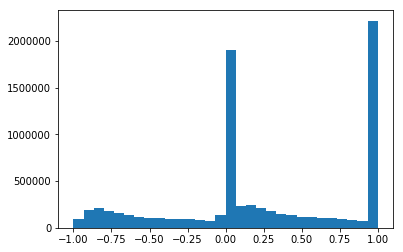

In [60]:
save_string = "/Users/adhyyan/Desktop/delta_hist_oneV2.pdf"
plt.hist(deltas.flatten(), 30)
plt.savefig(save_string, format = 'pdf')

In [61]:
x_pgd = x_test_flat + deltas

In [62]:
x_pgd_2d = x_pgd.reshape((10000, 28, 28))

In [63]:
np.max(x_pgd_2d)

1.0

In [64]:
x_test[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

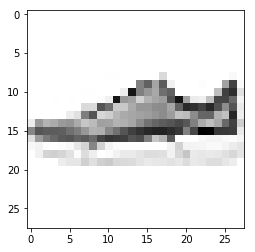

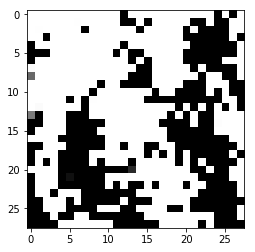

In [66]:
save_string = "/Users/adhyyan/Desktop/shoe_original_maxV2.pdf"
plt.imshow(x_test[9], cmap = 'Greys')
plt.savefig(save_string, format = 'pdf')
plt.show()

save_string = "/Users/adhyyan/Desktop/shoe_perturbed_maxV2.pdf"
plt.imshow(x_pgd_2d[9], cmap = 'Greys')
plt.savefig(save_string, format = 'pdf')

## Generate data for slave

In [16]:
with tf.variable_scope(scope_name, reuse = False) as scope:
        loss_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
        print("----Regular test accuracy and loss ----")
        print((loss_reg, acc_reg))
        
        z_train_slave = model.get_prediction(sess, x_train_slave_flat)
        z_test_slave = model.get_prediction(sess, x_test_flat)

Model was evaluated on benign data
I0716 15:32:00.077793 4654771648 feedforward_robust.py:675] Model was evaluated on benign data


----Regular test accuracy and loss ----
(0.48954064, 0.8214)


In [17]:
z_train_slave[0]

array([ 1.7228895,  5.857828 , -1.2812027,  8.737827 ,  2.7070222,
       -7.9261427, -0.3017945, -6.3297834, -1.1928556, -2.648211 ],
      dtype=float32)

# Train slave

In [18]:
#Setup - Dataset stuff
def slave_training():
    epochs = 20
    lr = 15e-4
    tf.reset_default_graph()
    sess = tf.Session()
    hidden_sizes = [64, 64, 32]
    dataset = ((x_train_slave_flat, z_train_slave), (x_test_flat, y_test))

    scope_name = "teacher_student_fashion"
    if not load_weights:
        with tf.variable_scope(scope_name, reuse = tf.AUTO_REUSE) as scope:

            logdir = tensorboard_dir + str(counter)

            #Create model
            writer = tf.summary.FileWriter(logdir)
            model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma, classification = False)
            sess.run(tf.global_variables_initializer())
            print("Created model successfully. Now going to train")

            #Train model
            model.fit(sess, x_train_slave_flat, z_train_slave, training_epochs = epochs, reg_op = reg , lr = lr)

            """
            #Save weights
            weights = tf.trainable_variables()
            #weights = model.get_weights()[0] + model.get_weights()[1]
            saver = tf.train.Saver(weights)
            weights_path = saver.save(sess, weights_dir + "model_" + str(counter) + ".ckpt")
            print("Saved model at %s"%weights_path)
            """
            loss_real_train, acc_train = model.evaluate(sess, x_train_slave_flat, z_train_slave)

            #Test model - regular, fgsm adv, pgd adv
                        
            loss_class_reg, acc_reg = model.evaluate(sess, x_test_flat, y_test)
            print("----Regular test loss and accuracy ----")
            print((loss_class_reg, acc_reg))
            
            loss_real_reg, acc_real_reg = model.evaluate(sess, x_test_flat, z_test_slave)
            print("----Real test loss and accuracy comparing to teacher ----")
            print((loss_real_reg, acc_real_reg))

            loss_fgsm, acc_fgsm = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = False)
            print("----FGSM test loss and accuracy ----")
            print((loss_fgsm, acc_fgsm))

            loss_pgd, acc_pgd = model.adv_evaluate(sess, x_test_flat, y_test, eps_test, pgd = True, eta=pgd_eta, num_iter = pgd_num_iter)
            print("----PGD test loss and accuracy ----")
            print((loss_pgd , acc_pgd))
            
            slave_train_confidences = model.get_prediction(sess, x_train_slave_flat)
            slave_test_confidences = model.get_prediction(sess, x_test_flat)
            
            return loss_real_train, acc_train, loss_real_reg, acc_real_reg, acc_reg, slave_train_confidences, slave_test_confidences
        
        

In [19]:
tup = slave_training()

Initialized instance variables of the robust model class
I0716 15:32:00.509573 4654771648 feedforward_robust.py:32] Initialized instance variables of the robust model class
Created placeholders for x and y
I0716 15:32:00.520034 4654771648 feedforward_robust.py:40] Created placeholders for x and y
Created layers and tensor for logits
I0716 15:32:00.597544 4654771648 feedforward_robust.py:44] Created layers and tensor for logits
Added accuracy computation to the graph
I0716 15:32:00.606265 4654771648 feedforward_robust.py:48] Added accuracy computation to the graph
Added MSE loss computation to the graph
I0716 15:32:00.631170 4654771648 feedforward_robust.py:60] Added MSE loss computation to the graph
Model graph was created
I0716 15:32:00.636001 4654771648 feedforward_robust.py:62] Model graph was created


Created model successfully. Now going to train


Epoch: 0001    cost: 1.983510282 
I0716 15:32:02.383177 4654771648 feedforward_robust.py:763] Epoch: 0001    cost: 1.983510282 
Accuracy on batch: 1.000000
I0716 15:32:02.384288 4654771648 feedforward_robust.py:764] Accuracy on batch: 1.000000
Epoch: 0002    cost: 0.275234095 
I0716 15:32:04.087764 4654771648 feedforward_robust.py:763] Epoch: 0002    cost: 0.275234095 
Accuracy on batch: 1.000000
I0716 15:32:04.091649 4654771648 feedforward_robust.py:764] Accuracy on batch: 1.000000
Epoch: 0003    cost: 0.214438481 
I0716 15:32:05.208437 4654771648 feedforward_robust.py:763] Epoch: 0003    cost: 0.214438481 
Accuracy on batch: 1.000000
I0716 15:32:05.209533 4654771648 feedforward_robust.py:764] Accuracy on batch: 1.000000
Epoch: 0004    cost: 0.183780558 
I0716 15:32:06.316774 4654771648 feedforward_robust.py:763] Epoch: 0004    cost: 0.183780558 
Accuracy on batch: 1.000000
I0716 15:32:06.317914 4654771648 feedforward_robust.py:764] Accuracy on batch: 1.000000
Epoch: 0005    cost: 0.1

----Regular test loss and accuracy ----
(42.935635, 0.8207)
----Real test loss and accuracy comparing to teacher ----
(0.13625494, 0.9706)


Model is being evaluated on FGSM data
I0716 15:32:26.043533 4654771648 feedforward_robust.py:682] Model is being evaluated on FGSM data


ValueError: too many values to unpack (expected 2)

In [ ]:
a

In [ ]:
list(tup)

In [ ]:
df = pd.DataFrame()
df['mse on z_train'] = []
df['acc on z_train'] = []
df['mse on z_test'] = []
df['acc on z_test'] = []
df['acc on y_test'] = []

In [ ]:
train_confidences = []
test_confidences = []
for i in range(3):
    loss_real_train, acc_train, loss_real_reg, acc_real_reg, acc_reg, slave_train_confidences, slave_test_confidences = slave_training()
    df.loc[i] = [loss_real_train, acc_train, loss_real_reg, acc_real_reg, acc_reg]
    train_confidences.append(slave_train_confidences)
    test_confidences.append(slave_test_confidences)

In [ ]:
df

In [ ]:
#df.to_excel("ts_fashion_results.xlsx")  